<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [ ]:
!pip install --upgrade  tensorflow_text==2.9.*
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [ ]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<h4>Split it into training and test data set</h4>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])

In [ ]:
X_train.head(4)

768                                Sorry, I'll call later
4416    Yeah I should be able to, I'll text you when I...
2441    Great. I'm in church now, will holla when i ge...
831     U have a secret admirer. REVEAL who thinks U R...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [ ]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606919 , -0.14219381,  0.4960461 , ...,  0.42165333,
        -0.532214  ,  0.80312175],
       [-0.86023223, -0.21242939,  0.4915689 , ...,  0.3979803 ,
        -0.60506296,  0.8447167 ],
       [-0.7128864 , -0.15463923,  0.38401636, ...,  0.352787  ,
        -0.5099134 ,  0.73474115],
       [-0.8253345 , -0.3555054 , -0.5906963 , ..., -0.01613662,
        -0.6141756 ,  0.87230295],
       [-0.7504134 , -0.26812598, -0.26689604, ...,  0.02839445,
        -0.5938098 ,  0.79749876],
       [-0.78544384, -0.299497  ,  0.41027427, ...,  0.5222542 ,
        -0.4957355 ,  0.81507534]], dtype=float32)>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow.

**(1) Sequential**
**(2) Functional**

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')   #Used to instantiate a Keras tensor.
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [ ]:
model.fit(X_train, y_train, epochs=1)

131/131 [==============================] - 6367s 48s/step - loss: 0.4494 - accuracy: 0.8526 - precision: 0.0625 - recall: 0.0071


In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 657s 15s/step - loss: 0.3945 - accuracy: 0.8658 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.3945237100124359, 0.8657573461532593, 0.0, 0.0]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()  #2D TO 1D

44/44 [==============================] - 656s 15s/step


In [51]:
#confusion_matrix = metrics.confusion_matrix(actual, predicted)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted.round(), normalize='all')
cm

array([[0.86575736, 0.        ],
       [0.13424264, 0.        ]])

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["spam", "not-spam"])
cm_display

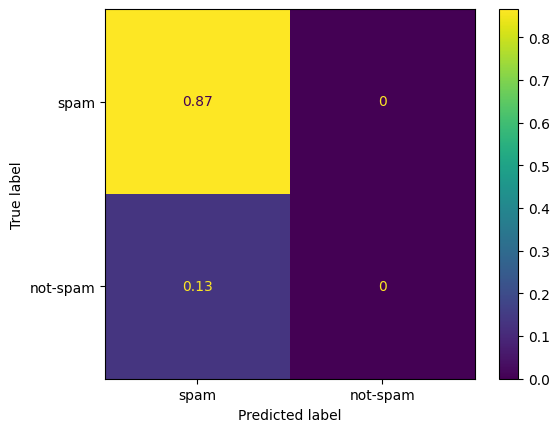

In [53]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

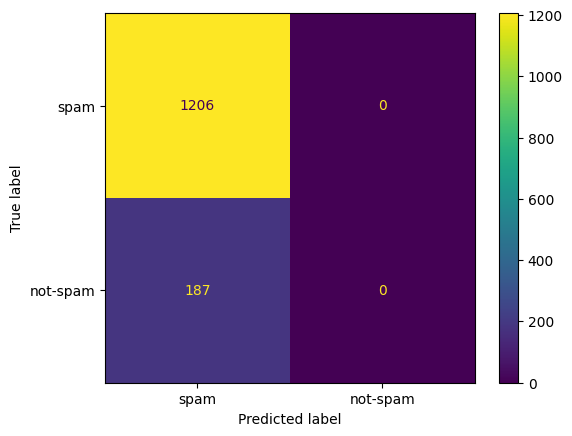

In [54]:
#confusion_matrix = metrics.confusion_matrix(actual, predicted)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["spam", "not-spam"])
cm_display.plot()
plt.show()

<h4>Inference</h4>

In [55]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "The account is hacked"
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.1402359 ],
       [0.14023589],
       [0.14023587],
       [0.14023587],
       [0.14023587],
       [0.14023587]], dtype=float32)